Dans ce notebook, on va lire le fichier .csv en espérant trouver une approche qui marche.

# 1ère tentative 

On va essayer de splitter les données en fonction de l'année (header Procédure : QJM - Année : 1888 par exemple).


In [1]:
lines = open('data/qjm_724bb7546a56afc333a5983a5b711b8e_1885_2016.csv').read()

In [2]:
len(lines)

713672

In [3]:
sublines = lines[:200000]

In [4]:
import re

In [5]:
year_delimiter = re.compile('Procédure : QJM - Année : (\d\d\d\d)')

In [6]:
splits = year_delimiter.split(sublines)

On s'attend à ce que le split commence dès le début donc on peut anticiper le fait que le premier split va être `''`, et qu'ensuite on va avoir une année puis un bout de texte:

In [7]:
len(splits)

61

In [8]:
splits[0]

''

In [9]:
splits[1]

'1885'

In [10]:
splits[3]

'1886'

On peut maintenant essayer de s'attaquer à un bloc. Par exemple 1886 (1885 est incomplet).

In [11]:
block = splits[4]

In [12]:
block

"\n\nCode station;Libellé station;Bassin versant (km²);Producteur;E-mail;\nH5920011;La Seine à Paris [Austerlitz avant création lacs];43800;DRIEE IDF;marc.valente@developpement-durable.gouv.fr;\n\nAnnée;1886;\n;\nDébits mensuels en m3/s;\n;QMM;QMN;V;\nJ;867.00;867.00;#;;\nF;875.00;875.00;#;;\nM;655.00;655.00;#;;\nA;283.00;283.00;#;;\nM;212.00;212.00;#;;\nJ;304.00;304.00;#;;\nJ;153.00;153.00;#;;\nA;;;;;\nS;111.00;111.00;#;;\nO;139.00;139.00;#;;\nN;239.00;239.00;#;;\nD;657.00;657.00;#;;\n\nStatistiques;\n;;Janvier;Février;Mars;Avril;Mai;Juin;Juillet;Août;Septembre;Octobre;Novembre;Décembre;1886\nEcoulement mensuel;Validité;Estimé;Estimé;Estimé;Estimé;Estimé;Estimé;Estimé;;Estimé;Estimé;Estimé;Estimé;;\n;Débit moyen (m3/s);867.00;875.00;655.00;283.00;212.00;304.00;153.00;;111.00;139.00;239.00;657.00;;\n;Débit moyen spécifique (l/s/km2);19.80;20.00;15.00;6.47;4.83;6.94;3.50;;2.54;3.18;5.46;15.00;;\n;Lame d'eau (mm);53.00;48.30;40.10;16.80;12.90;18.00;9.40;;6.60;8.50;14.20;40.20;;\n;\nEcoul

On va splitter le bloc sur le label maximum instantané.

In [13]:
block.split('Maximum instantané')[1].splitlines()[:4]

[';Débit (m3/s);1170.00;1320.00;995.00;401.00;348.00;442.00;348.00;207.00;149.00;348.00;488.00;1070.00;;',
 ';Date;30/01/1886\xa008:00;04/02/1886\xa015:00;08/03/1886\xa008:00;12/04/1886\xa008:00;14/05/1886\xa008:00;12/06/1886\xa015:00;01/07/1886\xa008:00;02/08/1886\xa008:00;11/09/1886\xa015:00;19/10/1886\xa015:00;20/11/1886\xa008:00;31/12/1886\xa015:00;\xa0;',
 ';Hauteur (cm);400.00;460.00;330.00;140.00;130.00;150.00;130.00;110.00;100.00;130.00;160.00;360.00;460.00;',
 ';Date;30/01/1886\xa008:00;04/02/1886\xa015:00;08/03/1886\xa008:00;12/04/1886\xa008:00;14/05/1886\xa008:00;12/06/1886\xa015:00;01/07/1886\xa008:00;02/08/1886\xa008:00;11/09/1886\xa015:00;19/10/1886\xa015:00;20/11/1886\xa008:00;31/12/1886\xa015:00;04/02/1886\xa015:00;']

Finalement, on peut extraire les données de débit avec les dates associées et les données de hauteur d'eau.

In [14]:
import pandas as pd
from io import StringIO

In [15]:
q = pd.read_csv(StringIO("\n".join(block.split('Maximum instantané')[1].splitlines()[:2])),
               sep=';', header=None, usecols=range(1, 14)).transpose()
q

,0,1
1,Débit (m3/s),Date
2,1170.00,30/01/1886 08:00
3,1320.00,04/02/1886 15:00
4,995.00,08/03/1886 08:00
5,401.00,12/04/1886 08:00
6,348.00,14/05/1886 08:00
7,442.00,12/06/1886 15:00
8,348.00,01/07/1886 08:00
9,207.00,02/08/1886 08:00
10,149.00,11/09/1886 15:00


In [16]:
h = pd.read_csv(StringIO("\n".join(block.split('Maximum instantané')[1].splitlines()[2:4])),
               sep=';', header=None, usecols=range(1, 14)).transpose()
h

,0,1
1,Hauteur (cm),Date
2,400.00,30/01/1886 08:00
3,460.00,04/02/1886 15:00
4,330.00,08/03/1886 08:00
5,140.00,12/04/1886 08:00
6,130.00,14/05/1886 08:00
7,150.00,12/06/1886 15:00
8,130.00,01/07/1886 08:00
9,110.00,02/08/1886 08:00
10,100.00,11/09/1886 15:00


On va voir ce qui se passe quand on a des données manquantes :

In [17]:
from ipywidgets import interact

In [18]:
@interact
def display_q(index=(0, int((len(splits) - 1)/2) - 1)):
    "Displays dataframe for q obtained from splits."
    block = splits[1 + 2 * index + 1]
    q = pd.read_csv(StringIO("\n".join(block.split('Maximum instantané')[1].splitlines()[:2])),
               sep=';', header=None, usecols=range(1, 14)).transpose()
    print(q)

               0                 1
1   Débit (m3/s)              Date
2         947.00  18/01/1899 08:00
3            NaN                  
4            NaN                  
5            NaN                  
6            NaN                  
7            NaN                  
8            NaN                  
9            NaN                  
10           NaN                  
11           NaN                  
12           NaN                  
13           NaN                  


In [19]:
@interact
def display_h(index=(0, int((len(splits) - 1)/2) - 1)):
    "Displays dataframe for q obtained from splits."
    block = splits[1 + 2 * index + 1]
    h = pd.read_csv(StringIO("\n".join(block.split('Maximum instantané')[1].splitlines()[2:4])),
               sep=';', header=None, usecols=range(1, 14)).transpose()
    print(h)

               0                 1
1   Hauteur (cm)              Date
2         310.00  18/01/1899 08:00
3         180.00  01/02/1899 08:00
4            NaN                  
5            NaN                  
6            NaN                  
7            NaN                  
8            NaN                  
9            NaN                  
10           NaN                  
11           NaN                  
12           NaN                  
13           NaN                  


On peut maintenant écrire le code d'extraction de la série de débit.

In [20]:
def extract_q_from_block(block):
    "Returns a pandas Series from a block of q values, indexed by date."
    q = pd.read_csv(StringIO("\n".join(block.split('Maximum instantané')[1].splitlines()[:2])),
               sep=';', header=None, usecols=range(1, 14)).transpose().drop(1).rename(columns={0:'q', 1:'date'}).dropna()
    index = pd.to_datetime(q.pop('date'), dayfirst=True)
    q = q.set_index(index)
    q = q.astype(float)
    return q

In [21]:
extract_q_from_block(block)

,q
date,
1886-01-30 08:00:00,1170.0
1886-02-04 15:00:00,1320.0
1886-03-08 08:00:00,995.0
1886-04-12 08:00:00,401.0
1886-05-14 08:00:00,348.0
1886-06-12 15:00:00,442.0
1886-07-01 08:00:00,348.0
1886-08-02 08:00:00,207.0
1886-09-11 15:00:00,149.0


In [22]:
@interact
def test_q_extraction(index=(0, int((len(splits) - 1)/2) - 1)):
    "Tests extraction of q on splits."
    block = splits[1 + 2 * index + 1]
    print(extract_q_from_block(block))

                         q
date                      
1899-01-18 08:00:00  947.0


In [23]:
df = pd.DataFrame([['a', 'b'], [1, 2]])
df

,0,1
0,a,b
1,1,2


In [24]:
df.drop(0)

,0,1
1,1,2


In [25]:
df

,0,1
0,a,b
1,1,2


In [26]:
df.rename(columns={0:'a', 1:'b'})

,a,b
0,a,b
1,1,2


In [27]:
df

,0,1
0,a,b
1,1,2


On peut maintenant faire la fonction d'extraction des hauteurs :

In [28]:
def extract_h_from_block(block):
    "Returns a pandas Series from a block of q values, indexed by date."
    h = pd.read_csv(StringIO("\n".join(block.split('Maximum instantané')[1].splitlines()[2:4])),
               sep=';', header=None, usecols=range(1, 14)).transpose().drop(1).rename(columns={0:'h', 1:'date'}).dropna()
    index = pd.to_datetime(h.pop('date'), dayfirst=True)
    h = h.set_index(index)
    h = h.astype(float)
    return h

In [29]:
@interact
def test_h_extraction(index=(0, int((len(splits) - 1)/2) - 1)):
    "Tests extraction of h on splits."
    block = splits[1 + 2 * index + 1]
    print(extract_h_from_block(block))

                         h
date                      
1899-01-18 08:00:00  310.0
1899-02-01 08:00:00  180.0


# Extraction du dataset 

In [30]:
import numpy as np

In [31]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

## Débit 

In [32]:
splits = year_delimiter.split(lines)
q_df = pd.concat([extract_q_from_block(block) for block in splits[2::2]])

<IPython.core.display.Javascript object>


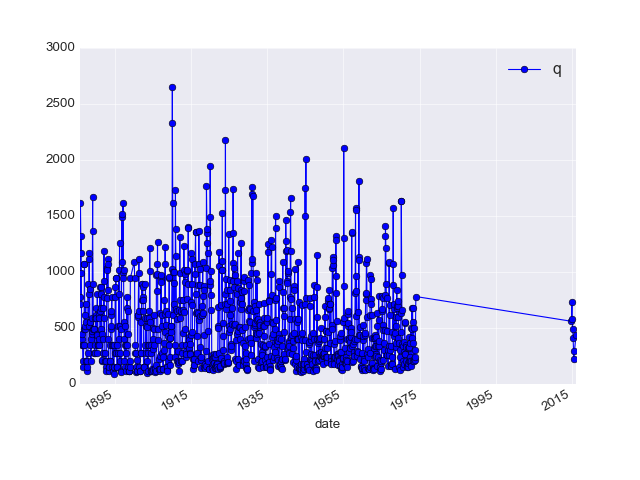

In [33]:
fig, ax = plt.subplots()
q_df.plot.line(style='-o', ax=ax)

## Hauteurs

In [34]:
splits = year_delimiter.split(lines)
h_df = pd.concat([extract_h_from_block(block) for block in splits[2::2]])

<IPython.core.display.Javascript object>


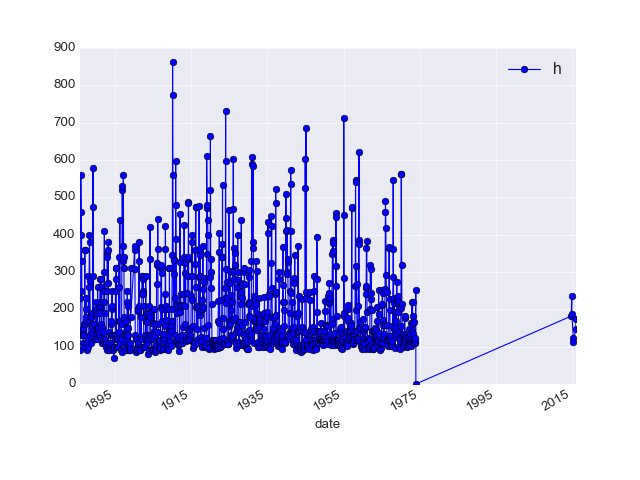

In [35]:
fig, ax = plt.subplots()
h_df.plot.line(style='-o', ax=ax)

# Export 

In [36]:
q_df.to_csv('data/export_q.csv')

In [37]:
h_df.to_csv('data/export_h.csv')

# Et depuis 1974 ? 

In [38]:
lines = open('data/qjm_5e6749ff5c8a98684d119f2a75d50c60_1974_2016.csv').read()

In [39]:
splits = year_delimiter.split(lines)
h_df2 = pd.concat([extract_h_from_block(block) for block in splits[2::2]])
# conversion vers des cm
h_df2.h = h_df2.h / 10
h_df2 = h_df2[h_df2.h > 0]

<IPython.core.display.Javascript object>


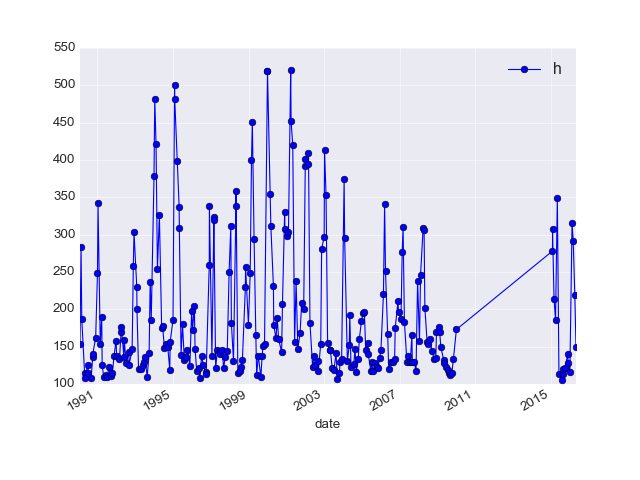

In [40]:
fig, ax = plt.subplots()
h_df2.plot.line(style='-o', ax=ax)

In [41]:
q_df2 = pd.concat([extract_q_from_block(block) for block in splits[2::2]])

In [42]:
q_df2

,q
date,


# Comparaison avant et après 

<IPython.core.display.Javascript object>


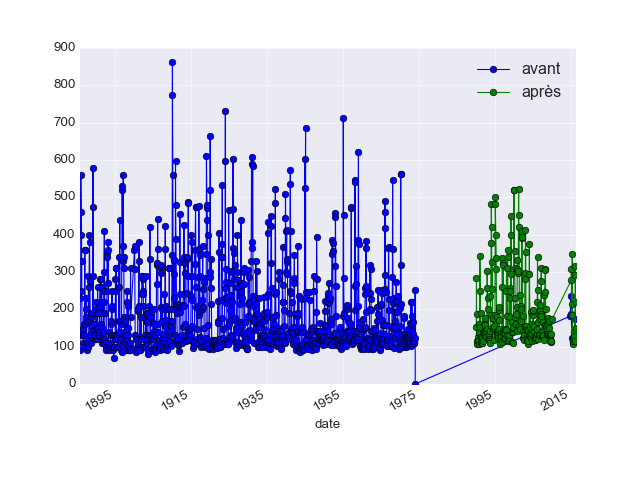

In [43]:
fig, ax = plt.subplots()
h_df.h.plot.line(style='-o', ax=ax, label='avant')
h_df2.h.plot.line(style='-o', ax=ax, label='après')
plt.legend()

On va rajouter la moyenne aussi :

In [44]:
h_df['h_moyen'] = [h_df.h.mean() for _ in h_df.h]

In [45]:
h_df2['h_moyen'] = [h_df2.h.mean() for _ in h_df2.h]

<IPython.core.display.Javascript object>


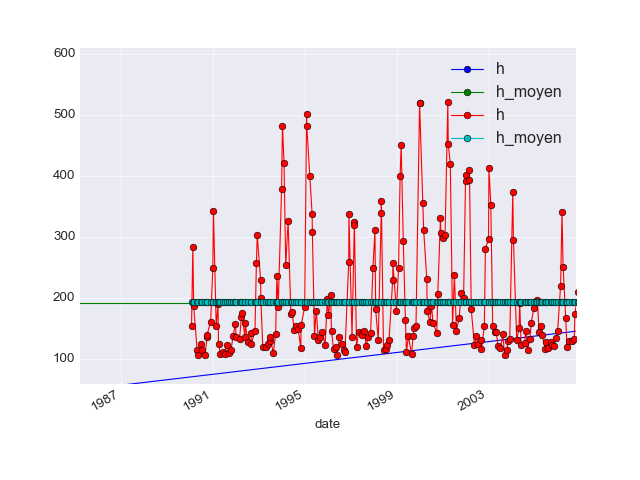

In [46]:
fig, ax = plt.subplots()
h_df.plot.line(style='-o', ax=ax, label='avant')
h_df2.plot.line(style='-o', ax=ax, label='après')
plt.legend()

On regarde les histogrammes :

<IPython.core.display.Javascript object>


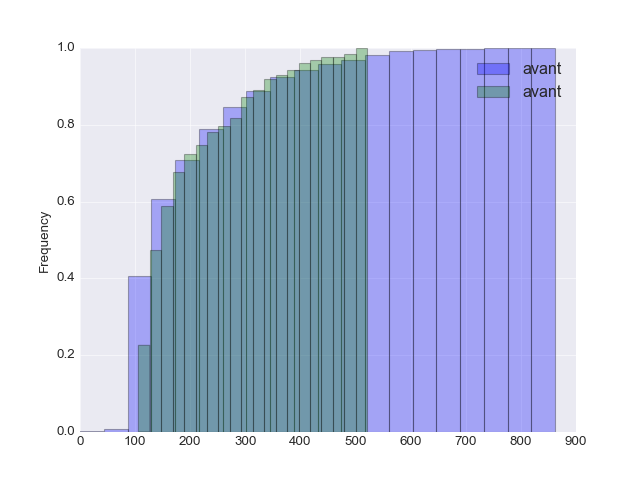

In [47]:
fig, ax = plt.subplots()
h_df.h.plot.hist(ax=ax, label='avant', cumulative=True, normed=True, bins=20, alpha=0.3)
h_df2.h.plot.hist(ax=ax, label='avant', cumulative=True, normed=True, bins=20, alpha=0.3)
plt.legend()

<IPython.core.display.Javascript object>


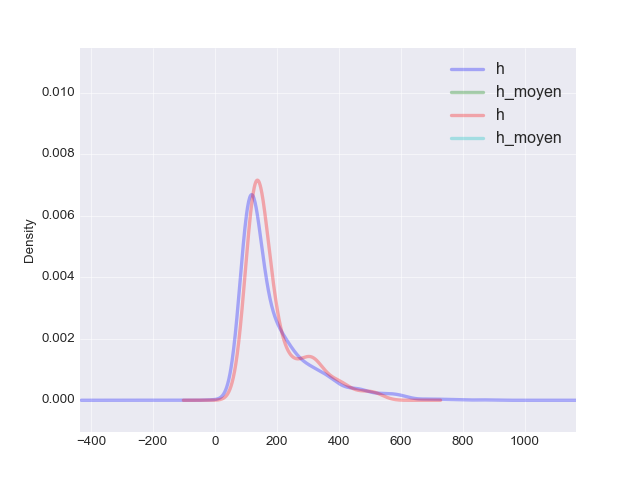

In [58]:
fig, ax = plt.subplots()
h_df.plot.kde(ax=ax, label='avant', alpha=0.3, lw=3)
h_df2[h_df2.h > 0].plot.kde(ax=ax, label='avant', alpha=0.3, lw=3)

## Test statistique 

On s'inspire comme d'habitude d'Allen Downey :

- Think Stats 2 <http://greenteapress.com/thinkstats2/html/thinkstats2010.html>
- Blog post there is only one test : <http://allendowney.blogspot.fr/2016/06/there-is-still-only-one-test.html>
- JakeVDP <https://www.youtube.com/watch?v=-7I7MWTX0gA>

In [49]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()


class DiffMeansPermute(HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [50]:
group1 = h_df.h.values
group2 = h_df2.h.values

In [51]:
group1.mean()

193.04716446124763

In [52]:
group2.mean()

194.08949416342412

In [53]:
test_data = (group1, group2)
test = DiffMeansPermute(data=test_data)

In [54]:
test.PValue(iters=50000)

0.89348

In [55]:
test.TestStatistic(test_data)

1.0423297021764881

<IPython.core.display.Javascript object>


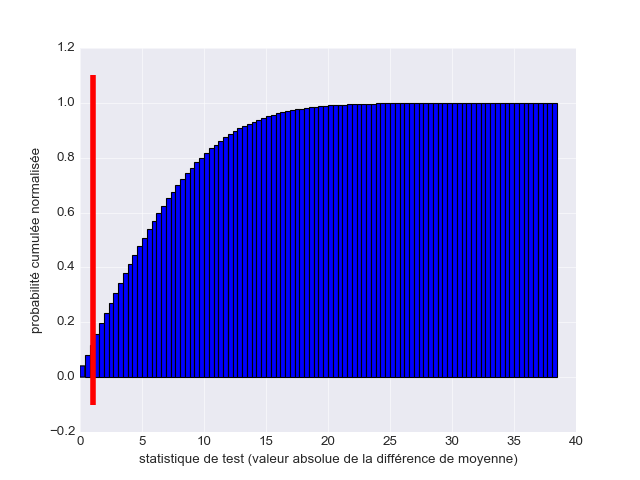

In [56]:
plt.figure()
plt.hist(test.test_stats, cumulative=True, bins=100, normed=True)
plt.vlines(test.TestStatistic(test_data), -0.1, 1.1, lw=5, colors='red')
plt.xlabel('statistique de test (valeur absolue de la différence de moyenne)')
plt.ylabel('probabilité cumulée normalisée')

# Exportation du fichier complet pour les hauteurs

In [62]:
pd.concat([h_df, h_df2])[['h']].to_csv('data/export_h_complet.csv')